In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

df = pd.read_csv('data/heart_2022.csv')
print ("Number of Columns: ", df.shape[1])
print ("Number of Rows: ", df.shape[0])

Number of Columns:  40
Number of Rows:  246022


In [20]:
from sklearn.model_selection import train_test_split

y = df['HadHeartAttack']
X = df.loc[:, df.columns != 'HadHeartAttack']


In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

# Redefine ordinal features and categories
ordinal_cats = [
    ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'], 
    ['5 or more years ago', 
     'Within past 5 years (2 years but less than 5 years ago)', 
     'Within past 2 years (1 year but less than 2 years ago)', 
     'Within past year (anytime less than 12 months ago)'], 
    ['All', '6 or more, but not all', '1 to 5', 'None of them'], 
    ['Current smoker - now smokes every day', 
     'Current smoker - now smokes some days', 
     'Former smoker', 
     'Never smoked'], 
    ['Use them every day', 'Use them some days', 'Not at all (right now)', 
     'Never used e-cigarettes in my entire life'], 
    ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 
     'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 
     'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 
     'Age 80 or older']
]

ordinal_ftrs = ['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory']
minmax_ftrs = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']

# Extract binary columns dynamically (only columns with 2 unique values)
binary_columns = [
    col for col in df.columns
    if df[col].nunique() == 2 and df[col].dtype == 'object' and col != 'HadHeartAttack'  # Exclude target variable
]

# Extract remaining categorical columns for one-hot encoding
remaining_onehot_ftrs = [
    col for col in df.columns
    if col not in binary_columns + ordinal_ftrs + minmax_ftrs + ['HadHeartAttack']
]

# Updated ColumnTransformer
preprocessor_fixed = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(), binary_columns),  # Encode binary columns as 0/1
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),  # Ordinal encoding
        ('onehot', OneHotEncoder(handle_unknown='ignore'), remaining_onehot_ftrs),  # Remaining categorical
        ('minmax', MinMaxScaler(), minmax_ftrs)  # Scaling for numerical features
    ]
)

# Define the final pipeline
clf_fixed = Pipeline(steps=[('preprocessor', preprocessor_fixed)])

y_target = df['HadHeartAttack']
X_features = df.loc[:, df.columns != 'HadHeartAttack']

# Fit and transform the data
X_transformed = clf_fixed.named_steps['preprocessor'].fit_transform(X_features)

# Get the shape of the transformed X
print("Shape of the transformed X:", X_transformed.shape)



Shape of the transformed X: (246022, 104)


In [34]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
import numpy as np

y_target = df['HadHeartAttack']
X_features = df.loc[:, df.columns != 'HadHeartAttack']

nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

# Loop through the different random states
for i in range(nr_states):
    print('Random state', i + 1)

    # First split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X_features, y_target, train_size=0.6, stratify=y_target, random_state=42 * i)

    # Second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, stratify=y_other, random_state=42 * i)

    # Preprocess the sets using the pipeline
    X_train_prep = clf_fixed.fit_transform(X_train)
    X_val_prep = clf_fixed.transform(X_val)
    X_test_prep = clf_fixed.transform(X_test)

    # Encode the target variable
    y_train_encoded = y_train.map({'No': 0, 'Yes': 1})
    y_val_encoded = y_val.map({'No': 0, 'Yes': 1})
    y_test_encoded = y_test.map({'No': 0, 'Yes': 1})

    # Define the parameter grid
    param_grid = {
        'max_depth': [1, 3, 10, 30, 100, 300, None],
        'max_features': [0.25, 0.5, 0.75, 1.0],
    }

    # Save train and validation scores
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    # Loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ', params)
        
        # Initialize the classifier
        clf_rf = RandomForestClassifier(**params, random_state=42 * i, n_jobs=-1, class_weight='balanced')
        clf_rf.fit(X_train_prep, y_train_encoded)  # Fit the model
        models.append(clf_rf)  # Save it
        
        # Calculate train and validation F2 scores
        y_train_pred = clf_rf.predict(X_train_prep)
        train_score[p] = fbeta_score(y_train_encoded, y_train_pred, beta=2, average='binary')  # Use F2 score
        y_val_pred = clf_rf.predict(X_val_prep)
        val_score[p] = fbeta_score(y_val_encoded, y_val_pred, beta=2, average='binary')  # Use F2 score
        print('   Train F2:', train_score[p], 'Validation F2:', val_score[p])
    
    # Print out model parameters that maximize validation F2 score
    print('Best model parameters:', ParameterGrid(param_grid)[np.argmax(val_score)])
    print('Corresponding validation F2 score:', np.max(val_score))
    
    # Collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    
    # Calculate and save the test F2 score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = fbeta_score(y_test_encoded, y_test_pred, beta=2, average='binary')  # Use F2 score
    print('Test F2 score:', test_scores[i])

# Print the average test F2 score across all random states
print('Average Test F2 Score:', np.mean(test_scores))


Random state 1
    {'max_features': 0.25, 'max_depth': 1}
   Train F2: 0.4890855652059047 Validation F2: 0.4769491187892064
    {'max_features': 0.5, 'max_depth': 1}
   Train F2: 0.49230769230769234 Validation F2: 0.49437709945961733
    {'max_features': 0.75, 'max_depth': 1}
   Train F2: 0.49230769230769234 Validation F2: 0.49437709945961733
    {'max_features': 1.0, 'max_depth': 1}
   Train F2: 0.49230769230769234 Validation F2: 0.49437709945961733
    {'max_features': 0.25, 'max_depth': 3}
   Train F2: 0.48567539234247625 Validation F2: 0.47605594010453456
    {'max_features': 0.5, 'max_depth': 3}
   Train F2: 0.48133890948262203 Validation F2: 0.46965145663472085
    {'max_features': 0.75, 'max_depth': 3}
   Train F2: 0.47715926696818417 Validation F2: 0.4651709703212455
    {'max_features': 1.0, 'max_depth': 3}
   Train F2: 0.47783089613798274 Validation F2: 0.4651053644342235
    {'max_features': 0.25, 'max_depth': 10}
   Train F2: 0.5645919682351712 Validation F2: 0.504596795376

In [37]:
import numpy as np

# Example array
rfc_array = np.array([0.5053752107925801, 0.5127401837928154, 0.5117579677919277, 0.5012109087080131, 0.5183505589538072])

# Calculate mean and standard deviation
mean = np.mean(rfc_array)
std_dev = np.std(rfc_array)

print(f"Random Forest Classifier Mean: {mean}")
print(f"Random Forest Classifier Standard Deviation: {std_dev}")

Random Forest Classifier Mean: 0.5098869660078287
Random Forest Classifier Standard Deviation: 0.00598170227196055


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import fbeta_score
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Assuming df is already defined
y_target = df['HadHeartAttack']
X_features = df.loc[:, df.columns != 'HadHeartAttack']

nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

# Loop through the different random states
for i in range(nr_states):
    print('Random state', i + 1)

    # First split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(
        X_features, y_target, train_size=0.6, stratify=y_target, random_state=42 * i
    )

    # Second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_other, y_other, train_size=0.5, stratify=y_other, random_state=42 * i
    )

    # Preprocess the sets using the pipeline
    X_train_prep = clf_fixed.fit_transform(X_train)
    X_val_prep = clf_fixed.transform(X_val)
    X_test_prep = clf_fixed.transform(X_test)

    # Encode the target variable
    y_train_encoded = y_train.map({'No': 0, 'Yes': 1})
    y_val_encoded = y_val.map({'No': 0, 'Yes': 1})
    y_test_encoded = y_test.map({'No': 0, 'Yes': 1})

    # Define the parameter grid for Logistic Regression
    param_grid = [
        {
            'penalty': ['l1', 'l2'],  # Different regularization techniques
            'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
            'solver': ['liblinear'],  # Solvers for optimization
            
        },
        {
            'penalty': ['elasticnet'],  # Different regularization techniques
            'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
            'solver': ['saga'],  # Solvers for optimization
            'l1_ratio': [0.5],
            'n_jobs': [-1],  # Include n_jobs only for saga solver
        },
    ]

    # Save train and validation scores
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    # Loop through all combinations of hyperparameter combos
    for p, params in enumerate(ParameterGrid(param_grid)):
        print('   ', params)

        # Exclude n_jobs for liblinear solver
        if params['solver'] == 'liblinear' and 'n_jobs' in params:
            params.pop('n_jobs')

        # Initialize the logistic regression classifier
        clf_lr = LogisticRegression(**params, random_state=42 * i, class_weight='balanced')
        clf_lr.fit(X_train_prep, y_train_encoded)  # Fit the model
        models.append(clf_lr)  # Save it

        # Calculate train and validation F2 scores
        y_train_pred = clf_lr.predict(X_train_prep)
        train_score[p] = fbeta_score(y_train_encoded, y_train_pred, beta=2, average='binary')  # Use F2 score
        y_val_pred = clf_lr.predict(X_val_prep)
        val_score[p] = fbeta_score(y_val_encoded, y_val_pred, beta=2, average='binary')  # Use F2 score
        print('   Train F2:', train_score[p], 'Validation F2:', val_score[p])

    # Print out model parameters that maximize validation F2 score
    print('Best model parameters:', ParameterGrid(param_grid)[np.argmax(val_score)])
    print('Corresponding validation F2 score:', np.max(val_score))

    # Collect and save the best model
    final_models.append(models[np.argmax(val_score)])

    # Calculate and save the test F2 score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = fbeta_score(y_test_encoded, y_test_pred, beta=2, average='binary')  # Use F2 score
    print('Test F2 score:', test_scores[i])

# Print the average test F2 score across all random states
print('Average Test F2 Score:', np.mean(test_scores))


Random state 1
    {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.49884194553150707 Validation F2: 0.48915396084844404
    {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.4986809035420472 Validation F2: 0.4925506415378108
    {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5097126999673522 Validation F2: 0.5046232539838678
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5102057385966906 Validation F2: 0.5052281833284472
    {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5111252591540558 Validation F2: 0.5063384433962265
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5117814920505503 Validation F2: 0.5056372549019608
    {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5118309399477807 Validation F2: 0.5056620422569734
    {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5118206588242972 Validation F2: 0.5060063741113018
    {'C': 10,

/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.3141463648264632 Validation F2: 0.31367298634853086
    {'C': 1, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.28654278099970387 Validation F2: 0.2859706785451715
    {'C': 10, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.28708012767158586 Validation F2: 0.28689679082970376
    {'C': 100, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.28015753357099576 Validation F2: 0.28056810028278395
Best model parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'n_jobs': -1, 'l1_ratio': 0.5, 'C': 0.01}
Corresponding validation F2 score: 0.5072321647462613
Test F2 score: 0.5010310290652004
Random state 2
    {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.4957486669548926 Validation F2: 0.49682417476662494
    {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.49623684457075046 Validation F2: 0.4963822589738771
    {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5054028065257428 Validation F2: 0.5036482052788795
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5056817260775827 Validation F2: 0.5031415907651844
    {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5066169040711888 Validation F2: 0.5042078481260397
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.506659936168827 Validation F2: 0.5044

/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.49280371973509124 Validation F2: 0.49124580671844126
    {'C': 1, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.5149811133710496 Validation F2: 0.5123150186901531
    {'C': 10, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.45667168794101326 Validation F2: 0.45459978485198616
    {'C': 100, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.4692720391499037 Validation F2: 0.46795247259643546
Best model parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'n_jobs': -1, 'l1_ratio': 0.5, 'C': 1}
Corresponding validation F2 score: 0.5123150186901531
Test F2 score: 0.5109061257771889
Random state 3
    {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.4997592681752528 Validation F2: 0.4954132846645214
    {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5004786641347165 Validation F2: 0.4959102594064034
    {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5113580409020779 Validation F2: 0.501435453262615
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5124459316085856 Validation F2: 0.5032270587664386
    {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5136149772947097 Validation F2: 0.503173828125
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5139589750311292 Validation F2: 0.50304803706413

/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.5360687587109854 Validation F2: 0.5290587492103601
    {'C': 1, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.4366097046949191 Validation F2: 0.43038264721606967
    {'C': 10, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.02979115479115479 Validation F2: 0.039551140544518026
    {'C': 100, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.5212526023594726 Validation F2: 0.5105406937786712
Best model parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'n_jobs': -1, 'l1_ratio': 0.5, 'C': 0.1}
Corresponding validation F2 score: 0.5290587492103601
Test F2 score: 0.5180094183530609
Random state 4
    {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5011157310044789 Validation F2: 0.4951597289448209
    {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.4999608058320922 Validation F2: 0.49884100477789867
    {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5102391311459321 Validation F2: 0.504738868595123
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.511051072556232 Validation F2: 0.5039748748650505
    {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5126021519464142 Validation F2: 0.5065069506063294
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5124030500376345 Validation F2: 0.506035969

/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.5105855083818944 Validation F2: 0.5012291052114061
    {'C': 1, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.35011999160515006 Validation F2: 0.34991197183098594
    {'C': 10, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.5012566540220734 Validation F2: 0.4950425261970772
    {'C': 100, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.3874303815813992 Validation F2: 0.38842820624727226
Best model parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
Corresponding validation F2 score: 0.5065069506063294
Test F2 score: 0.49851778656126483
Random state 5
    {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.4918346212060862 Validation F2: 0.49507307088113484
    {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.492449625208434 Validation F2: 0.4928857063145169
    {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5031395386667534 Validation F2: 0.5069471434123591
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.5041255460281507 Validation F2: 0.5031856356791196
    {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
   Train F2: 0.5054031181850731 Validation F2: 0.5032546390750996
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
   Train F2: 0.505169554898072 Validation F2: 0.5025710682060736
    {'C': 1, 'penalty': 

/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.4822541116721292 Validation F2: 0.48604960141718334
    {'C': 1, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.4770973093846931 Validation F2: 0.4799948038451546
    {'C': 10, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


   Train F2: 0.47755119712516775 Validation F2: 0.479366312699646
    {'C': 100, 'l1_ratio': 0.5, 'n_jobs': -1, 'penalty': 'elasticnet', 'solver': 'saga'}
   Train F2: 0.5189128054144301 Validation F2: 0.5146782590028444
Best model parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'n_jobs': -1, 'l1_ratio': 0.5, 'C': 100}
Corresponding validation F2 score: 0.5146782590028444
Test F2 score: 0.5311809410876948
Average Test F2 Score: 0.511929060168882


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [35]:
import numpy as np

# Example array
lr_array = np.array([0.5010310290652004, 0.5109061257771889, 0.5180094183530609, 0.49851778656126483, 0.5311809410876948])

# Calculate mean and standard deviation
mean = np.mean(lr_array)
std_dev = np.std(lr_array)

print(f"Logistic Regression Mean: {mean}")
print(f"Logistic Regression Standard Deviation: {std_dev}")


Logistic Regression Mean: 0.511929060168882
Logistic Regression Standard Deviation: 0.011893539515593732


In [6]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import fbeta_score
import numpy as np
import xgboost as xgb

# Assuming `df` is already defined
y_target = df['HadHeartAttack']
X_features = df.loc[:, df.columns != 'HadHeartAttack']

nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

# Loop through the different random states
for i in range(nr_states):
    print('Random state', i + 1)

    # First split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X_features, y_target, train_size=0.6, stratify=y_target, random_state=42 * i)

    # Second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, stratify=y_other, random_state=42 * i)

    # Preprocess the sets using the pipeline
    X_train_prep = clf_fixed.fit_transform(X_train)
    X_val_prep = clf_fixed.transform(X_val)
    X_test_prep = clf_fixed.transform(X_test)

    # Encode the target variable
    y_train_encoded = y_train.map({'No': 0, 'Yes': 1})
    y_val_encoded = y_val.map({'No': 0, 'Yes': 1})
    y_test_encoded = y_test.map({'No': 0, 'Yes': 1})

    # Define the parameter grid
    param_grid = {
        'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],  # Step size shrinkage used in updates to prevent overfitting
        'max_depth': [5, 10, 30, 100, 300, None] # Minimum loss reduction to split a node
    }

    # Save train and validation scores
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    positive_class_count = sum(y_train_encoded == 1)
    negative_class_count = sum(y_train_encoded == 0)
    scale_pos_weight = negative_class_count / positive_class_count

    # Loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ', params)
        
        # Initialize the XGBoost classifier
        clf_xgb = xgb.XGBClassifier(**params, random_state=42 * i, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
        clf_xgb.fit(X_train_prep, y_train_encoded)  # Fit the model
        models.append(clf_xgb)  # Save it
        
        # Calculate train and validation F2 scores
        y_train_pred = clf_xgb.predict(X_train_prep)
        train_score[p] = fbeta_score(y_train_encoded, y_train_pred, beta=2, average='binary')  # Use F2 score
        y_val_pred = clf_xgb.predict(X_val_prep)
        val_score[p] = fbeta_score(y_val_encoded, y_val_pred, beta=2, average='binary')  # Use F2 score
        print('   Train F2:', train_score[p], 'Validation F2:', val_score[p])
    
    # Print out model parameters that maximize validation F2 score
    print('Best model parameters:', ParameterGrid(param_grid)[np.argmax(val_score)])
    print('Corresponding validation F2 score:', np.max(val_score))
    
    # Collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    
    # Calculate and save the test F2 score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = fbeta_score(y_test_encoded, y_test_pred, beta=2, average='binary')  # Use F2 score
    print('Test F2 score:', test_scores[i])

# Print the average test F2 score across all random states
print('Average Test F2 Score:', np.mean(test_scores))


Random state 1
    {'max_depth': 5, 'learning_rate': 0.001}
   Train F2: 0.47171791373701333 Validation F2: 0.4577132323186907
    {'max_depth': 10, 'learning_rate': 0.001}
   Train F2: 0.5382933563141348 Validation F2: 0.47165282511641304
    {'max_depth': 30, 'learning_rate': 0.001}
   Train F2: 0.8418633799874661 Validation F2: 0.4482801829459307
    {'max_depth': 100, 'learning_rate': 0.001}
   Train F2: 0.8610743130635443 Validation F2: 0.44339864259188116
    {'max_depth': 300, 'learning_rate': 0.001}
   Train F2: 0.8610743130635443 Validation F2: 0.44339864259188116
    {'max_depth': None, 'learning_rate': 0.001}
   Train F2: 0.46484923233955683 Validation F2: 0.44588155207624236
    {'max_depth': 5, 'learning_rate': 0.01}
   Train F2: 0.5052726919842143 Validation F2: 0.49313935383417673
    {'max_depth': 10, 'learning_rate': 0.01}
   Train F2: 0.5686177657034659 Validation F2: 0.4882347100873709
    {'max_depth': 30, 'learning_rate': 0.01}
   Train F2: 0.9139455782312925 Valid

In [7]:
import numpy as np

# Example array
xgb_array = np.array([0.501180986123413, 0.5019201788926159, 0.5007715665289462, 0.4938302195351603, 0.5093394954746775])

# Calculate mean and standard deviation
mean = np.mean(xgb_array)
std_dev = np.std(xgb_array)

print(f"XGBoost Mean: {mean}")
print(f"XGBoost Standard Deviation: {std_dev}")


XGBoost Mean: 0.5014084893109626
XGBoost Standard Deviation: 0.004920371655114912


In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

# Redefine ordinal features and categories
ordinal_cats = [
    ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'], 
    ['5 or more years ago', 
     'Within past 5 years (2 years but less than 5 years ago)', 
     'Within past 2 years (1 year but less than 2 years ago)', 
     'Within past year (anytime less than 12 months ago)'], 
    ['All', '6 or more, but not all', '1 to 5', 'None of them'], 
    ['Current smoker - now smokes every day', 
     'Current smoker - now smokes some days', 
     'Former smoker', 
     'Never smoked'], 
    ['Use them every day', 'Use them some days', 'Not at all (right now)', 
     'Never used e-cigarettes in my entire life'], 
    ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 
     'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 
     'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 
     'Age 80 or older']
]

ordinal_ftrs = ['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory']
minmax_ftrs = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']

# Extract binary columns dynamically (only columns with 2 unique values)
binary_columns = [
    col for col in df.columns
    if df[col].nunique() == 2 and df[col].dtype == 'object' and col != 'HadHeartAttack'  # Exclude target variable
]

# Extract remaining categorical columns for one-hot encoding
remaining_onehot_ftrs = [
    col for col in df.columns
    if col not in binary_columns + ordinal_ftrs + minmax_ftrs + ['HadHeartAttack']
]

# Updated ColumnTransformer
preprocessor_fixed = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(), binary_columns),  # Encode binary columns as 0/1
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),  # Ordinal encoding
        ('onehot', OneHotEncoder(handle_unknown='ignore'), remaining_onehot_ftrs),  # Remaining categorical
        ('minmax', MinMaxScaler(), minmax_ftrs)  # Scaling for numerical features
    ]
)

# Define the final pipeline
clf_fixed = Pipeline(steps=[('preprocessor', preprocessor_fixed)])


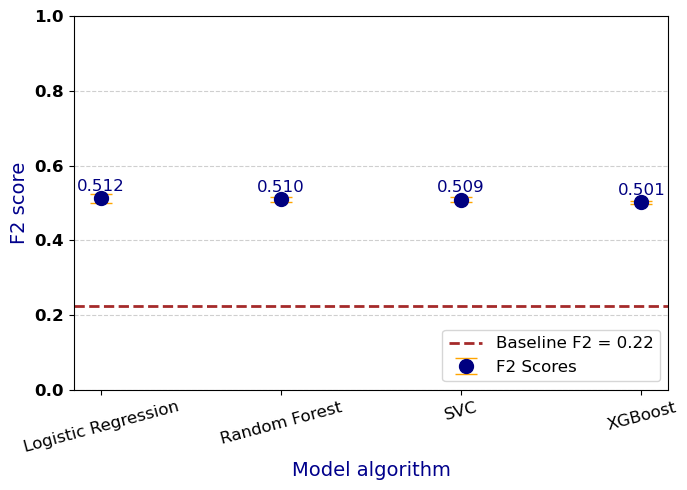

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Data for F2 scores
algorithms = ['Logistic Regression', 'Random Forest', 'SVC', 'XGBoost']
mean_f2_scores = [0.51193, 0.50989, 0.50863, 0.50141]
std_devs = [0.01189, 0.00616, 0.00598, 0.00492]
baseline_f2 = 0.2241

# X positions
x_pos = np.arange(len(algorithms))

# Create the plot
plt.figure(figsize=(7, 5))
plt.errorbar(x_pos, mean_f2_scores, yerr=std_devs, fmt='o', color='navy', ecolor='orange',
             capsize=8, markersize=10, elinewidth=2, label='F2 Scores')

# Add baseline as a horizontal line
plt.axhline(y=baseline_f2, color='brown', linestyle='--', linewidth=2, label=f'Baseline F2 = {baseline_f2:.2f}')

# Customize plot appearance
plt.ylabel('F2 score', fontsize=14, color='darkblue')
plt.xlabel('Model algorithm', fontsize=14, color='darkblue')
plt.xticks(x_pos, algorithms, fontsize=12, rotation=15)
plt.ylim(0, 1)
plt.yticks(fontsize=12, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc='lower right')

# Annotate each F2 score above the points
for i, score in enumerate(mean_f2_scores):
    plt.text(x_pos[i], score + 0.02, f"{score:.3f}", ha='center', fontsize=12, color='navy')

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.savefig('Fig6.jpeg')
plt.show()


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import fbeta_score
import numpy as np

y_target = df['HadHeartAttack']
X_features = df.loc[:, df.columns != 'HadHeartAttack']

# First split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(
    X_features, y_target, train_size=0.6, stratify=y_target, random_state=168
)

# Second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other, train_size=0.5, stratify=y_other, random_state=168
)

 # Preprocess the sets using the pipeline
X_train_prep = clf_fixed.fit_transform(X_train)
X_val_prep = clf_fixed.transform(X_val)
X_test_prep = clf_fixed.transform(X_test)

# Encode the target variable
y_train_encoded = y_train.map({'No': 0, 'Yes': 1})
y_val_encoded = y_val.map({'No': 0, 'Yes': 1})
y_test_encoded = y_test.map({'No': 0, 'Yes': 1})

clf_lr = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=100, n_jobs=-1, random_state=168, class_weight='balanced', solver='saga')
clf_lr.fit(X_train_prep, y_train_encoded)  # Fit the model
y_test_pred = clf_lr.predict(X_test_prep)

f2_score = fbeta_score(y_test_encoded, y_test_pred, beta=2, average='binary')
print(f2_score)


0.5311809410876948


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


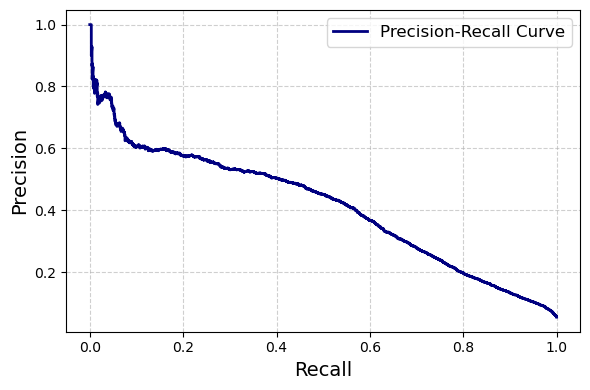

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute predicted probabilities for the test set
y_test_proba = clf_lr.predict_proba(X_test_prep)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_encoded, y_test_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Precision-Recall Curve', color='navy', linewidth=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.grid(alpha=0.6, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('Fig8.jpeg')
# Show the plot
plt.show()


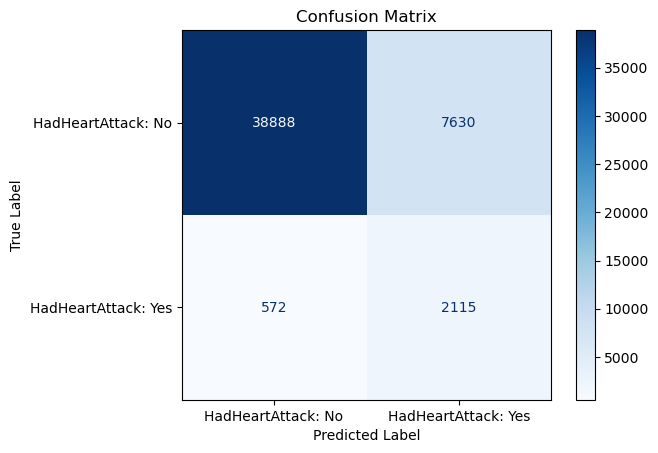

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)

# Customize the Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['HadHeartAttack: No', 'HadHeartAttack: Yes'])
disp.plot(cmap='Blues', values_format='d')  # Use 'd' for integer formatting
disp.ax_.set_title("Confusion Matrix")
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
plt.savefig('Fig7.jpeg')
plt.show()





In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# Calculate the metrics
accuracy = accuracy_score(y_test_encoded, y_test_pred)
precision = precision_score(y_test_encoded, y_test_pred, average='binary')
recall = recall_score(y_test_encoded, y_test_pred, average='binary')
f1 = f1_score(y_test_encoded, y_test_pred, average='binary')
f2 = fbeta_score(y_test_encoded, y_test_pred, beta=2, average='binary')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8336
Precision: 0.2143
Recall: 0.7678
F1 Score: 0.3351


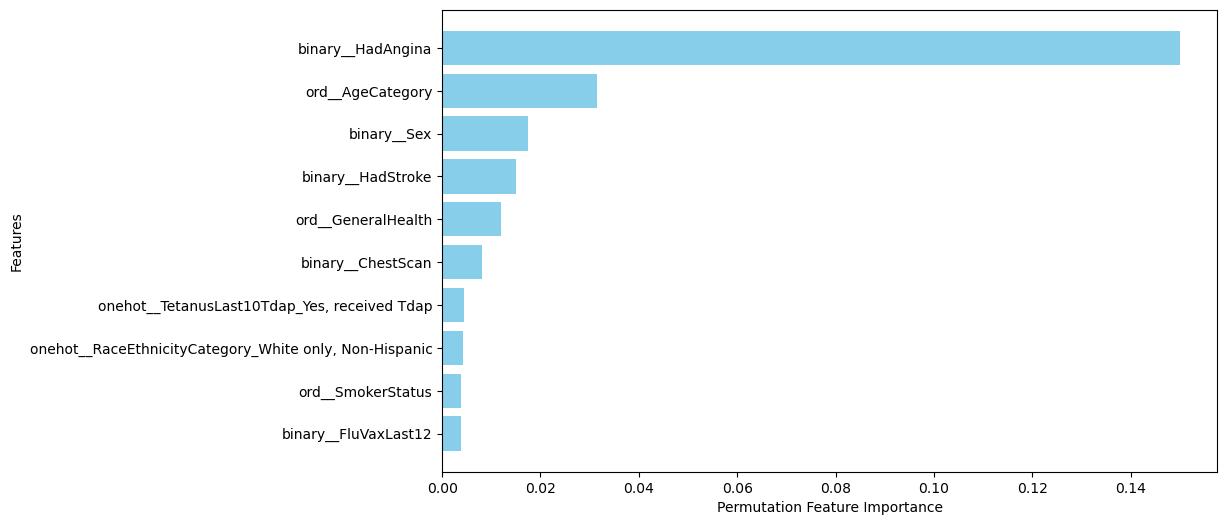

In [55]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, fbeta_score

# Define the custom scorer for F2 score
f2_scorer = make_scorer(fbeta_score, beta=2)

# Compute permutation importance
result = permutation_importance(
    clf_lr,  # Trained logistic regression model
    X_test_prep,  # Preprocessed test features
    y_test_encoded,  # Encoded test labels
    scoring=f2_scorer,  # F2 score as the metric
    n_repeats=10,  # Number of permutations
    random_state=42  # Random state for reproducibility
)

# Extract feature importance values and standard deviations
importance_values = result.importances_mean
importance_std = result.importances_std

# Get feature names from the preprocessor pipeline
feature_names = clf_fixed['preprocessor'].get_feature_names_out()

# Combine feature names with their importance values and standard deviations
feature_importance_with_std = sorted(
    zip(feature_names, importance_values, importance_std),
    key=lambda x: x[1],
    reverse=True
)

# Select the top 10 most important features
top_features_with_std = feature_importance_with_std[:10]
top_feature_names, top_importance_values, top_importance_stds = zip(*top_features_with_std)

# Plot the top 10 features in order of mean importance with error bars for standard deviation
plt.figure(figsize=(10, 6))
plt.barh(
    top_feature_names,  # Feature names
    top_importance_values,  # Mean importance values
    align='center',
    capsize=5,
    color='skyblue',
    ecolor='black',
    error_kw={'elinewidth': 1.5}
)
plt.xlabel("Permutation Feature Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.savefig('Fig9.jpeg')
plt.show()

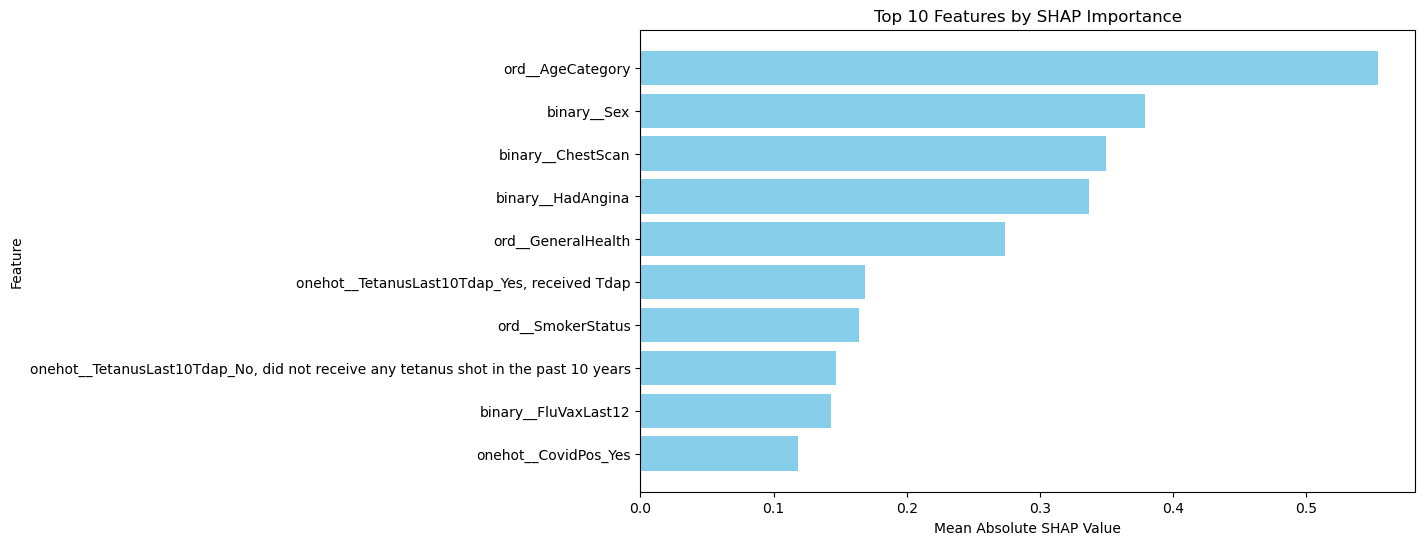

In [63]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Initialize the SHAP explainer using the trained model and preprocessed training data
explainer = shap.Explainer(clf_lr, X_train_prep)  # Use preprocessed training data

# Compute SHAP values for the preprocessed test data
shap_values = explainer(X_test_prep)

# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Get feature names from the preprocessor
feature_names = clf_fixed['preprocessor'].get_feature_names_out()

# Combine feature names with SHAP values and sort by importance
shap_feature_importance = sorted(
    zip(feature_names, shap_importance),
    key=lambda x: x[1],
    reverse=True
)

# Select the top 10 most important features
top_10_features = shap_feature_importance[:10]
top_feature_names, top_importance_values = zip(*top_10_features)

# Plot the top 10 features as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importance_values)), top_importance_values, align='center', color='skyblue')
plt.yticks(range(len(top_importance_values)), top_feature_names)
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("Top 10 Features by SHAP Importance")
plt.gca().invert_yaxis()
plt.show()


/Users/arpitdang/anaconda3/envs/data1030/lib/python3.12/site-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


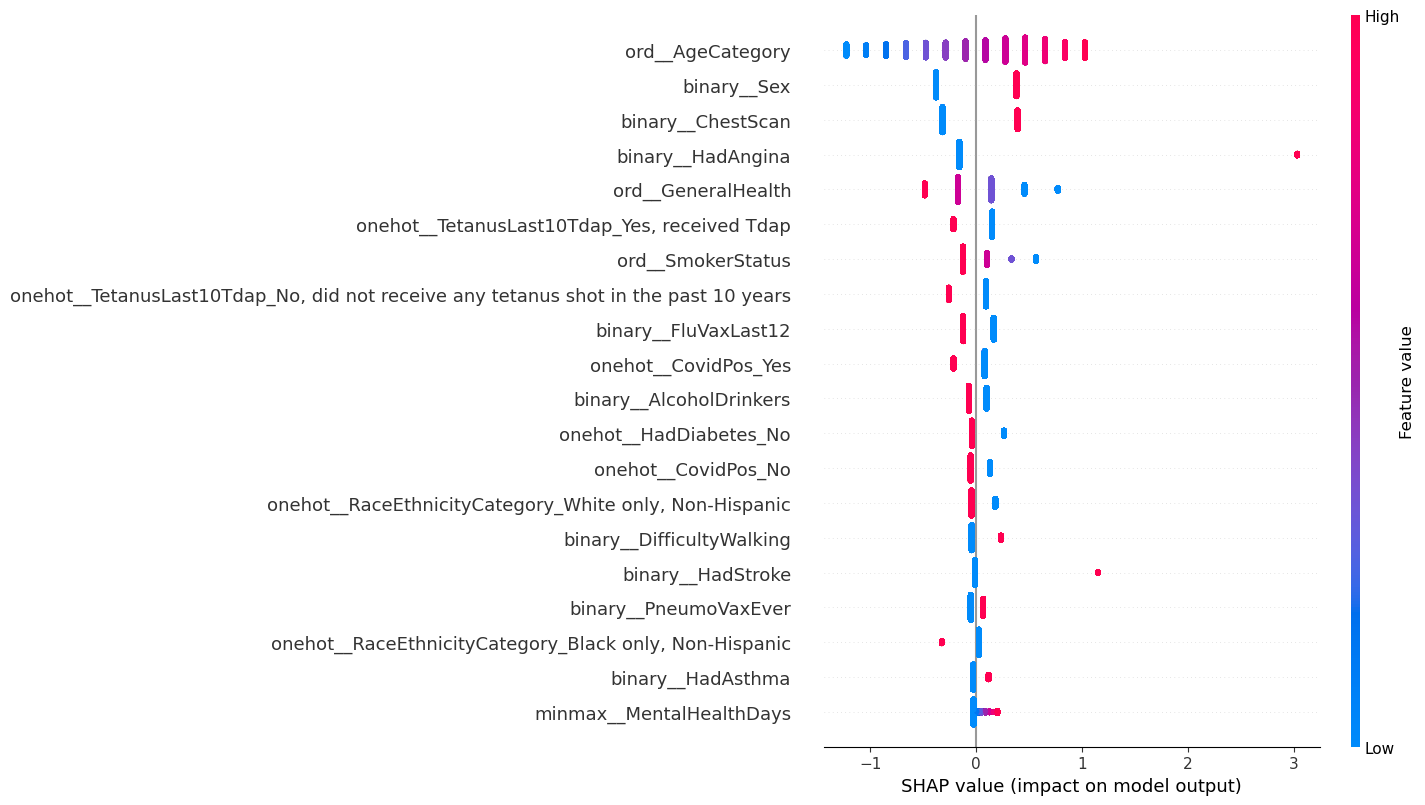

<Figure size 640x480 with 0 Axes>

In [57]:
import shap
import matplotlib.pyplot as plt

# Explicitly fit the preprocessor to the training data
clf_fixed['preprocessor'].fit(X_train)

# Get the transformed feature names
feature_names = clf_fixed['preprocessor'].get_feature_names_out()

# Initialize the SHAP explainer using the fitted model and preprocessed training data
explainer = shap.Explainer(clf_lr, X_train_prep)

# Compute SHAP values for the preprocessed test data
shap_values = explainer(X_test_prep)

# Create the summary plot
shap.summary_plot(
    shap_values,
    features=X_test_prep,
    feature_names=feature_names  # Use the properly extracted feature names
)
plt.savefig('Fig11.jpeg')

In [40]:
# Find indices where HadHeartAttack is True (Yes) and False (No) in the test set
index_heart_attack_yes = y_test[y_test == 'Yes'].index
index_heart_attack_no = y_test[y_test == 'No'].index

# Print a few example indices for each
print("Indices where 'HadHeartAttack' is True (Yes):", index_heart_attack_yes[:5].tolist())
print("Indices where 'HadHeartAttack' is False (No):", index_heart_attack_no[:5].tolist())


Indices where 'HadHeartAttack' is True (Yes): [130703, 105957, 179002, 232586, 18938]
Indices where 'HadHeartAttack' is False (No): [23976, 203457, 155686, 40707, 39698]


In [51]:
import shap

# Initialize the SHAP explainer for the fitted logistic regression model
explainer = shap.Explainer(clf_lr, X_test_prep)

# Compute SHAP values for the test set
shap_values = explainer(X_test_prep)

# Select specific indices for analysis
indices = [18938, 155]

# Create SHAP force plots for specific data points using JavaScript rendering
for index in indices:
    # Generate and render the force plot in HTML/JS
    force_plot = shap.force_plot(
        base_value=shap_values.base_values[index],
        shap_values=shap_values.values[index],
        features=X_test_prep[index],
        feature_names=clf_fixed.named_steps['preprocessor'].get_feature_names_out()
    )
    shap.save_html(f"force_plot_{index}.html", force_plot)  # Save the plot as an HTML file


In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
import numpy as np

# Define feature groups
ordinal_cats = [
    ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'], 
    ['5 or more years ago', 
     'Within past 5 years (2 years but less than 5 years ago)', 
     'Within past 2 years (1 year but less than 2 years ago)', 
     'Within past year (anytime less than 12 months ago)'], 
    ['All', '6 or more, but not all', '1 to 5', 'None of them'], 
    ['Current smoker - now smokes every day', 
     'Current smoker - now smokes some days', 
     'Former smoker', 
     'Never smoked'], 
    ['Use them every day', 'Use them some days', 'Not at all (right now)', 
     'Never used e-cigarettes in my entire life'], 
    ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 
     'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 
     'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 
     'Age 80 or older']
]

ordinal_ftrs = ['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory']
minmax_ftrs = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']

# Extract binary columns dynamically (only columns with 2 unique values)
binary_columns = [
    col for col in df.columns
    if df[col].nunique() == 2 and df[col].dtype == 'object' and col != 'HadHeartAttack'  # Exclude target variable
]

# Extract remaining categorical columns for one-hot encoding
remaining_onehot_ftrs = [
    col for col in df.columns
    if col not in binary_columns + ordinal_ftrs + minmax_ftrs + ['HadHeartAttack']
]

# Updated ColumnTransformer
preprocessor_fixed = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(), binary_columns),  # Encode binary columns as 0/1
        ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),  # Ordinal encoding
        ('onehot', OneHotEncoder(handle_unknown='ignore'), remaining_onehot_ftrs),  # Remaining categorical
        ('minmax', MinMaxScaler(), minmax_ftrs)  # Scaling for numerical features
    ]
)

# Add final scaler
final_scaler = StandardScaler()

# Define the pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor_fixed),
    ('final_scaler', final_scaler),
    ('classifier', LogisticRegression(
        penalty='elasticnet', l1_ratio=0.5, C=100, n_jobs=-1,
        class_weight='balanced', solver='saga'))
])

# Split the dataset
y_target = df['HadHeartAttack']
X_features = df.loc[:, df.columns != 'HadHeartAttack']

X_train, X_other, y_train, y_other = train_test_split(
    X_features, y_target, train_size=0.6, stratify=y_target, random_state=168
)

X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other, train_size=0.5, stratify=y_other, random_state=168
)

# Encode the target variable
y_train_encoded = y_train.map({'No': 0, 'Yes': 1})
y_test_encoded = y_test.map({'No': 0, 'Yes': 1})

# Train the pipeline
clf.fit(X_train, y_train_encoded)

# Predict on the test set
y_test_pred = clf.predict(X_test)

# Calculate the F2 score
f2_score = fbeta_score(y_test_encoded, y_test_pred, beta=2, average='binary')
print(f"F2 Score: {f2_score}")


F2 Score: 0.5160298638559508


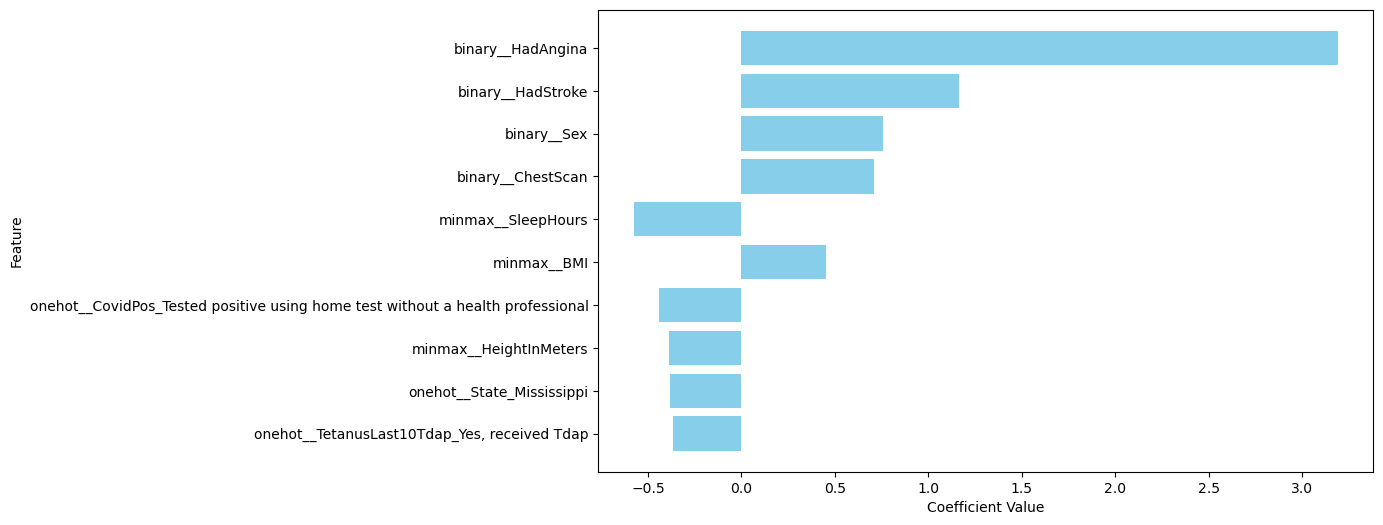

In [56]:
import matplotlib.pyplot as plt

# Extract the coefficients and feature names
coefficients = clf_lr.coef_[0]  # Coefficients for the logistic regression model
feature_names = clf['preprocessor'].get_feature_names_out()

# Combine feature names with their coefficients
feature_coefficients = sorted(
    zip(feature_names, coefficients),
    key=lambda x: abs(x[1]),  # Sort by absolute coefficient values
    reverse=True
)

# Select the top 10 most important features based on coefficients
top_features = feature_coefficients[:10]
top_feature_names, top_coeff_values = zip(*top_features)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_coeff_values)), top_coeff_values, align='center', color='skyblue',)
plt.yticks(range(len(top_coeff_values)), top_feature_names)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.savefig('Fig10.jpeg')
plt.show()
